In [1]:
from dataclasses import dataclass
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.contrib.concurrent import process_map
from collections import defaultdict
from tqdm import tqdm
import sys
sys.path.append('..')
from utils.project_dataclasses import *

In [2]:
pred_func = np.load('/home/avic/OOD_Orientation_Generalization/canonical_x_heatmap32_corr.npy')
pred_func_mask = np.max(pred_func, axis=0) > 0.2

In [3]:
def corr(arr1, arr2):
    return np.corrcoef(arr1.flatten(), arr2.flatten())[0, 1]

def invariance(pre_act, post_act):
    return 1 - np.abs((post_act - pre_act) / (post_act + pre_act))

In [4]:
@dataclass
class Result:
    num_fully_seen: int
    run: int
    pred_acc: float
    xpred_acc: float
    a_corr: float
    e_corr: float
    ae_corr: float
    all_corr: float
    
    partial_heatmap: Arr
    partial_invariances: Arr
    cross_instance_invariance: Arr

In [5]:
results = {num_fully_seen:[None] * 5 for num_fully_seen in range(10, 50, 10)}

In [6]:
def analyze_exp(job_i):
    exp = ExpData.from_job_i('/home/avic/OOD_Orientation_Generalization', '/home/avic/om2/OODOG/', job_i)
    
    exp.partial_ood_frame.df['in_pred_func'] = np.isin(exp.partial_ood_frame.df.image_idx.values, np.where(pred_func_mask.flatten())[0])
    
    partial_heatmap = Arr('/home/avic/', 'test')
    partial_heatmap.arr = np.zeros(exp.dataset_resolution ** 3)
    
    for frame, correct in ((exp.partial_validation_frame, exp.eval_data.partial_validation_correct),
                           (exp.partial_ood_frame, exp.eval_data.partial_ood_correct)):
        for flat_cubelet_i, indices in frame.df.groupby('image_idx', sort=False).indices.items():
            partial_heatmap.arr[flat_cubelet_i] = correct.arr[indices].mean()
            
    partial_heatmap.arr = partial_heatmap.arr.reshape((exp.dataset_resolution,) * 3)
    
    pred_acc, xpred_acc = partial_heatmap.arr[pred_func_mask].mean(), partial_heatmap.arr[~pred_func_mask].mean()
    a_corr, e_corr, ae_corr, all_corr = (corr(partial_heatmap.arr, pred_func[0]),
                                         corr(partial_heatmap.arr, pred_func[1]),
                                         corr(partial_heatmap.arr, np.max(pred_func[[0,1]], axis=0)),
                                         corr(partial_heatmap.arr, np.max(pred_func, axis=0)))
            
    # for activation in exp.eval_data.activations:
    #     activation.arr = activation.arr / activation.arr.max(axis=0)
    
    accumulated_activation = sum([activation.arr.sum() for activation in exp.eval_data.activations])
    max_activation = max([activation.arr.max() for activation in exp.eval_data.activations])

    for activation_threshold in np.linspace(max_activation, 0, 100):
        if (sum([(activation.arr[activation.arr > activation_threshold]).sum() for activation in exp.eval_data.activations]) / accumulated_activation) > 0.5:
            break

    partial_ood_mean_activations = np.zeros((len(exp.partial_instances), 2, 512))
    for (in_pred_func, instance_name), indices in exp.partial_ood_frame.df.groupby(['in_pred_func', 'instance_name'], sort=False).indices.items():
        partial_ood_mean_activations[exp.partial_instances.index(instance_name), int(in_pred_func)] = np.mean(exp.eval_data.partial_ood_activations.arr[indices], axis=0)

    partial_validation_mean_activations = np.zeros((len(exp.partial_instances), 512))
    for instance_name, indices in exp.partial_validation_frame.df.groupby('instance_name', sort=False).indices.items():
        partial_validation_mean_activations[exp.partial_instances.index(instance_name)] = np.mean(exp.eval_data.partial_validation_activations.arr[indices], axis=0)
        
    full_validation_mean_activations = np.zeros((len(exp.full_instances), 512))
    for instance_name, indices in exp.full_validation_frame.df.groupby('instance_name', sort=False).indices.items():
        full_validation_mean_activations[exp.full_instances.index(instance_name)] = np.mean(exp.eval_data.full_validation_activations.arr[indices], axis=0)

    partial_ood_mean_activations = np.where(partial_ood_mean_activations > activation_threshold, partial_ood_mean_activations, np.nan)    
    partial_validation_mean_activations = np.where(partial_validation_mean_activations > activation_threshold, partial_validation_mean_activations, np.nan)
    full_validation_mean_activations = np.where(full_validation_mean_activations > activation_threshold, full_validation_mean_activations, np.nan)

    partial_invariance = Arr('/home/avic/', 'test')
    partial_invariance.arr = np.zeros((2, 10, 512))
    for i, instance_name in enumerate(exp.partial_instances):
        base_mean_activation = partial_validation_mean_activations[i]
        instance_ood_mean_activations = partial_ood_mean_activations[i]
        partial_invariance.arr[0][i] = invariance(base_mean_activation, instance_ood_mean_activations[1])
        partial_invariance.arr[1][i] = invariance(base_mean_activation, instance_ood_mean_activations[0])
        
    cross_instance_invariance = Arr('/home/avic/', 'test')
    cross_instance_invariance.arr = invariance(partial_validation_mean_activations, np.expand_dims(full_validation_mean_activations, 1))
    

    return Result(exp.num_fully_seen, exp.run, pred_acc, xpred_acc, a_corr, e_corr, ae_corr, all_corr, partial_heatmap, partial_invariance, cross_instance_invariance)

In [7]:
for result in process_map(analyze_exp, range(20, 40), max_workers=8):
    results[result.num_fully_seen][result.run] = result

  0%|          | 0/20 [00:00<?, ?it/s]

In [8]:
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec

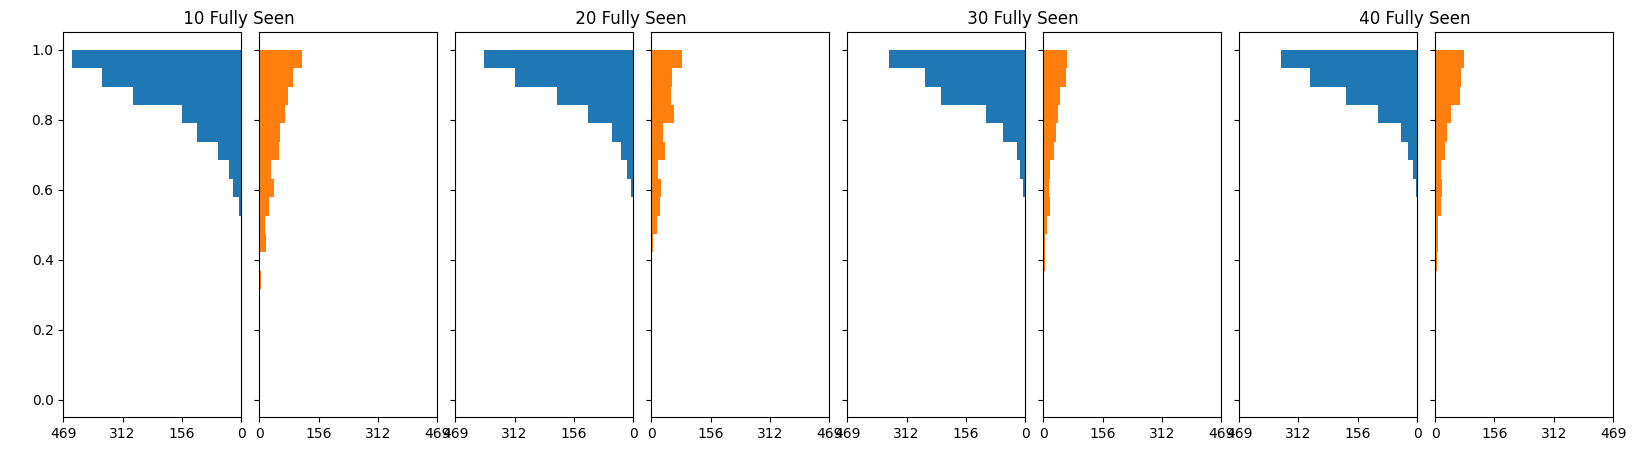

In [62]:
plt.close()
plt.style.use('default')

max_x_limit = 0

fig, axes = plt.subplots(nrows=1, ncols=8, sharey=True, figsize=(20, 5))
for x in range(4):
    num_fully_seen = (x + 1) * 10
    
    for y in range(2):
        ax = axes[(x * 2) + y]
        data = np.stack([results[num_fully_seen][z].partial_invariances.arr[y] for z in range(5)]).flatten()
        ax.hist(data, bins=np.linspace(0, 1, 20), color=sns.color_palette()[y], orientation="horizontal")
        max_x_limit = max(max_x_limit, ax.get_xlim()[1])
        if y == 0:
            ax.set_title(f'                                 {num_fully_seen} Fully Seen')
            
    # ax = axes[x]
    # data = np.stack([results[num_fully_seen][z].cross_instance_invariance.arr for z in range(5)]).flatten()
    # ax.hist(data, bins=np.linspace(0, 1, 50), color=sns.color_palette()[0], orientation="horizontal")
    # max_x_limit = max(max_x_limit, ax.get_xlim()[1])
    # ax.set_title(f'{num_fully_seen} Fully Seen')

ticks = np.linspace(0, max_x_limit, 4)
# labels = np.round(ticks / (results[10][0].partial_invariances.arr[0].flatten().shape[0] * 5), 3)
# for x in range(4):
#     axes[x].set_xlim(0, max_x_limit * ((x + 1) / 4))
plt.setp(axes, xlim=(0, max_x_limit), xticks=ticks, xticklabels=ticks.astype(int))
plt.subplots_adjust(wspace=0.1)
for x in range(8):
    if x % 2 == 0:
        axes[x].invert_xaxis()

# create legend
# handles = [Rectangle((0,0), 1, 1, color=sns.color_palette()[i], ec="k") for i in range(1)]
# labels= ['in pred func', 'outside pred func']
# axes[x].legend(handles, labels, loc='lower right')

In [14]:
[np.stack([results[num_fully_seen][z].cross_instance_invariance.arr for z in range(5)]).flatten() for num_fully_seen in (10, 20, 30, 40)]

[array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan]),
 array([nan, nan, nan, ..., nan, nan, nan])]

In [34]:
[np.stack([results[num_fully_seen][z].partial_invariances.arr[0] for z in range(5)]).flatten().shape for num_fully_seen in (10, 20, 30, 40)]

[(25600,), (25600,), (25600,), (25600,)]

In [8]:
a = pd.DataFrame(columns=range(10, 50, 10), data=np.stack([np.stack([results[num_fully_seen][z].partial_invariances.arr[0] for z in range(5)]).flatten() for num_fully_seen in (10, 20, 30, 40)]).T)
a['in_pred_func'] = True
b = pd.DataFrame(columns=range(10, 50, 10), data=np.stack([np.stack([results[num_fully_seen][z].partial_invariances.arr[1] for z in range(5)]).flatten() for num_fully_seen in (10, 20, 30, 40)]).T)
b['in_pred_func'] = False
c = pd.concat((a, b))

In [27]:
def get_df(num_fully_seen):
    d = pd.DataFrame(data=np.stack([results[num_fully_seen][z].cross_instance_invariance.arr for z in range(5)]).flatten())
    d['num_fully_seen'] = num_fully_seen
    return d
e = pd.concat([get_df(x) for x in (10, 20, 30, 40)]).reset_index()

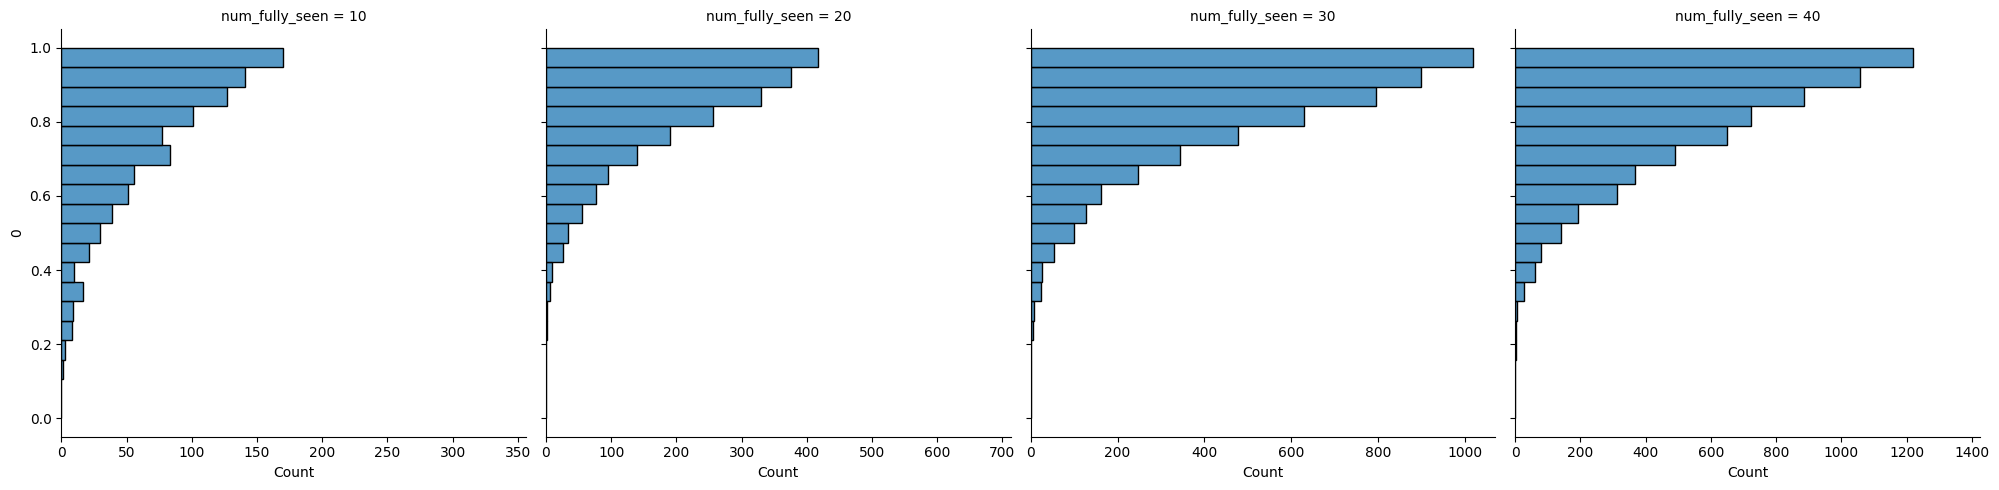

In [114]:
fg = sns.displot(data=e, y=0, bins=np.linspace(0, 1, 20), col='num_fully_seen', facet_kws={'sharex': False})

x_limits = np.array([ax.get_xlim()[1] for ax in fg.axes[-1]])
max_x_limit_idx = np.argmax(x_limits / (np.linspace(10, 40, 4) / 40))
max_x_limit = x_limits[max_x_limit_idx]
for ax, num_fully_seen in zip(fg.axes[-1], (10, 20, 30, 40)):
    ax.set_xlim(0, max_x_limit * (num_fully_seen / ((max_x_limit_idx + 1) * 10)))

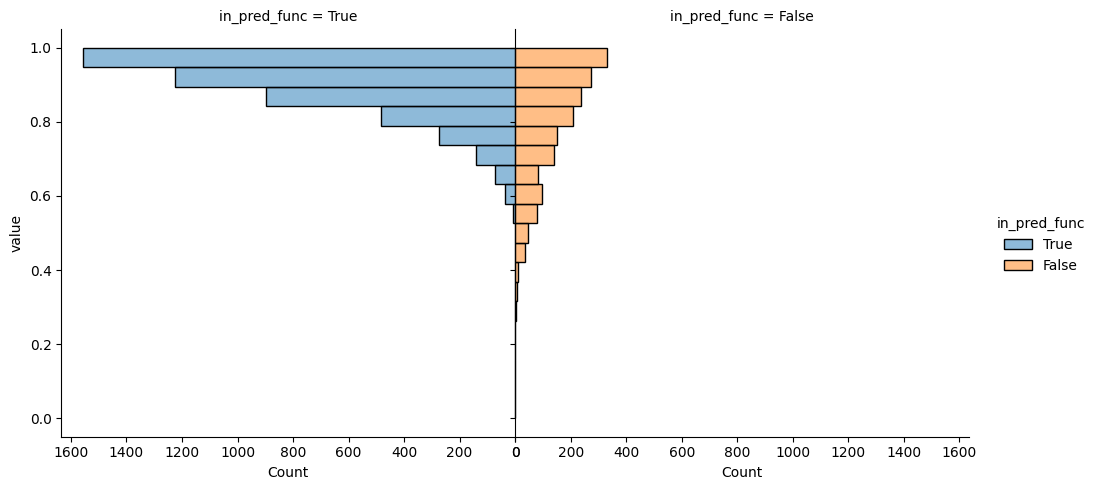

In [130]:
# facetgrid takes share x
fg = sns.displot(data=c.melt('in_pred_func'), y='value', hue='in_pred_func', bins=np.linspace(0, 1, 20), col='in_pred_func', col_order=[True, False], hue_order=[True, False], facet_kws={'sharex': False})

x_limits = np.array([ax.get_xlim()[1] for ax in fg.axes.flatten()])
for i, ax in enumerate(fg.axes.flatten()):
    ax.set_xlim(0, max(x_limits))
    if i % 2 == 0:
        ax.invert_xaxis()
plt.subplots_adjust(wspace=0)

In [30]:
a = list(fg.axes[0, 0]._shared_axes['x'])[0][1]
fg.axes[0, 0]._shared_axes['x'].remove(a)

IndexError: list index out of range

In [29]:
list(fg.axes[0, 0]._shared_axes['x'])

[[<AxesSubplot:title={'center':'in_pred_func = True'}, xlabel='Count'>],
 [<AxesSubplot:title={'center':'in_pred_func = True'}, xlabel='Count'>,
  <AxesSubplot:title={'center':'in_pred_func = False'}, xlabel='Count', ylabel='value'>]]

In [ ]:
all_results = pd.DataFrame([vars(r) for num_fully_seen in results.keys() for r in results[num_fully_seen]])

In [ ]:
# melted_results = all_results[['pred_acc', 'xpred_acc', 'num_fully_seen']].melt(['num_fully_seen'])
melted_results = all_results[['a_corr', 'e_corr', 'ae_corr', 'all_corr', 'num_fully_seen']].melt(['num_fully_seen'])
sns.lineplot(data=melted_results, x='num_fully_seen', y='value', hue='variable', errorbar='se')

In [25]:
exp = ExpData.from_job_i('/home/avic/OOD_Orientation_Generalization', '/home/avic/om2/OODOG/', 23)
    
exp.partial_ood_frame.df['in_pred_func'] = np.isin(exp.partial_ood_frame.df.image_idx.values, np.where(pred_func_mask.flatten())[0])

partial_heatmap = Arr('/home/avic/', 'test')
partial_heatmap.arr = np.zeros(exp.dataset_resolution ** 3)

for frame, correct in ((exp.partial_validation_frame, exp.eval_data.partial_validation_correct),
                       (exp.partial_ood_frame, exp.eval_data.partial_ood_correct)):
    for flat_cubelet_i, indices in frame.df.groupby('image_idx', sort=False).indices.items():
        partial_heatmap.arr[flat_cubelet_i] = correct.arr[indices].mean()

partial_heatmap.arr = partial_heatmap.arr.reshape((exp.dataset_resolution,) * 3)

pred_acc, xpred_acc = partial_heatmap.arr[pred_func_mask].mean(), partial_heatmap.arr[~pred_func_mask].mean()
a_corr, e_corr, ae_corr, all_corr = (corr(partial_heatmap.arr, pred_func[0]),
                                     corr(partial_heatmap.arr, pred_func[1]),
                                     corr(partial_heatmap.arr, np.max(pred_func[[0,1]], axis=0)),
                                     corr(partial_heatmap.arr, np.max(pred_func, axis=0)))

for activation in exp.eval_data.activations:
    activation.arr = activation.arr / activation.arr.max(axis=0)

partial_ood_mean_activations = np.zeros((len(exp.partial_instances), 2, 512))
for (in_pred_func, instance_name), indices in exp.partial_ood_frame.df.groupby(['in_pred_func', 'instance_name'], sort=False).indices.items():
    partial_ood_mean_activations[exp.partial_instances.index(instance_name), int(in_pred_func)] = np.mean(exp.eval_data.partial_ood_activations.arr[indices], axis=0)

partial_validation_mean_activations = np.zeros((len(exp.partial_instances), 512))
for instance_name, indices in exp.partial_validation_frame.df.groupby('instance_name', sort=False).indices.items():
    partial_validation_mean_activations[exp.partial_instances.index(instance_name)] = np.mean(exp.eval_data.partial_validation_activations.arr[indices], axis=0)

partial_ood_mean_activations = np.where(partial_ood_mean_activations > 0.2, partial_ood_mean_activations, np.nan)    
partial_validation_mean_activations = np.where(partial_validation_mean_activations > 0.2, partial_validation_mean_activations, np.nan)

partial_invariance = Arr('/home/avic/', 'test')
partial_invariance.arr = np.zeros((2, 10, 512))
for i, instance_name in enumerate(exp.partial_instances):
    base_mean_activation = partial_validation_mean_activations[i]
    instance_ood_mean_activations = partial_ood_mean_activations[i]
    partial_invariance.arr[0][i] = invariance(base_mean_activation, instance_ood_mean_activations[1])
    partial_invariance.arr[1][i] = invariance(base_mean_activation, instance_ood_mean_activations[0])

/tmp/ipykernel_195723/2170116061.py:22: RuntimeWarning: invalid value encountered in divide
  activation.arr = activation.arr / activation.arr.max(axis=0)


In [39]:
full_validation_mean_activations = np.zeros((len(exp.full_instances), 512))
for instance_name, indices in exp.full_validation_frame.df.groupby('instance_name', sort=False).indices.items():
    full_validation_mean_activations[exp.full_instances.index(instance_name)] = np.mean(exp.eval_data.full_validation_activations.arr[indices], axis=0)

full_validation_mean_activations = np.where(full_validation_mean_activations > 0.2, full_validation_mean_activations, np.nan)

invariance(partial_validation_mean_activations, np.expand_dims(full_validation_mean_activations, 1)).shape

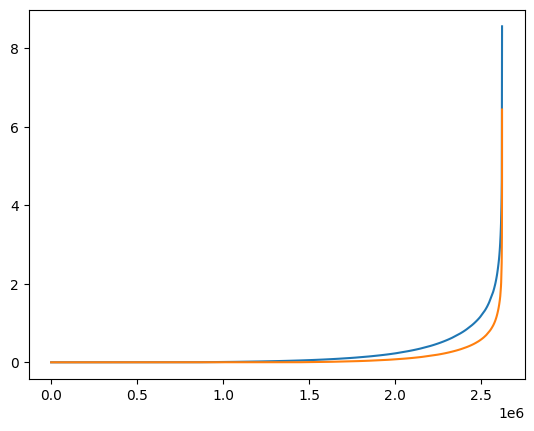

In [ ]:
exp = ExpData.from_job_i('/home/avic/OOD_Orientation_Generalization', '/home/avic/om2/OODOG/', 20)
plt.plot((np.sort(exp.eval_data.partial_validation_activations.arr.flatten())))
exp = ExpData.from_job_i('/home/avic/OOD_Orientation_Generalization', '/home/avic/om2/OODOG/', 23)
plt.plot((np.sort(exp.eval_data.partial_validation_activations.arr.flatten())))